# Research Question 1: GLM
**Research Question:** What is a state’s predicted relative renewable energy production based on state characteristics (average annual temperature, sunlight exposure, political leaning, wind and water characteristics, electricity price, urbanization level, and number of power plants)? 

## 1.1 Library Imports

In [1]:
# Import libraries, all previously used in course
# NOTE: we used Regressors instead of Classifiers for KNN and RF upon OH consultation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Note Python version
import sys
print(f"Python version: {sys.version}")

# Set random seed
np.random.seed(42)

Python version: 3.11.10 | packaged by conda-forge | (main, Sep 22 2024, 14:10:38) [GCC 13.3.0]


## 1.2 Data Cleaning and Model Setup

### File Structure

#### cleaned_datasets:
- `total_data.csv` (cleaned datasets from EDA)
- `windiest-states-2024.csv` (wind data)
- `cleaned_net_gen.csv` (net energy generation data)
- `cleaned_weather.csv` (temperature, sun, and precipitation data)
- `cleaned_state_political_party.csv` (political preference data)

In [2]:
def load_and_clean_datasets():
    # Load raw datasets
    datasets = {
        'total': pd.read_csv('total_data.csv'),
        'wind': pd.read_csv('cleaned_datasets/windiest-states-2024.csv'),
        'net_gen': pd.read_csv('cleaned_datasets/cleaned_net_gen.csv'),
        'weather': pd.read_csv('cleaned_datasets/cleaned_weather.csv'),
        'policy': pd.read_csv('cleaned_datasets/cleaned_state_political_party.csv')
    }
    
    # Clean wind data
    wind_columns = {
        'WindiestStatesAverageWindSpeedMPH': 'Wind Speed (mph)',
        'MeanWindSpeed328ft': 'Avg Wind Speed (328Ft)',
        'MeanWindPower328ft': 'Avg Wind Power (328Ft)',
        'MeanWindSpeed33ft': 'Avg Wind Speed (33Ft)'
    }
    datasets['wind'].rename(columns=wind_columns, inplace=True)
    
    return datasets

def normalize_column(df, column):
    return (df[column] - df[column].mean()) / df[column].std()

def prepare_data(datasets):
    # Merge datasets
    data = datasets['total'].merge(datasets['wind'], on='State')
    data.rename(columns={'State': 'state'}, inplace=True)
    
    # Clean numeric columns
    data['water percentage'] = data['water percentage'].str.rstrip('%').astype(float) / 100
    data['total area (mile^2)'] = pd.to_numeric(data['total area (mile^2)'].str.replace(',', ''))
    
    # Create intermediate dataframe
    wind_water = data[['state', 'water percentage', 'Avg Wind Power (328Ft)', 
                      'total area (mile^2)', 'Urban Population', 'num_plants', 
                      'Electricity Price (cents/kWh)']]
    
    # Clean and rename supplementary datasets
    net_gen = datasets['net_gen'][['state', 'total renewable production', 'total production']].rename(
        columns={'total renewable production': 'renewable_production', 
                'total production': 'total_production'})
    
    weather = datasets['weather'][['state', 'avg annual temp (F)', 'avg annual sunlight (kJ/m^2)']].rename(
        columns={'avg annual temp (F)': 'avg_temp', 
                'avg annual sunlight (kJ/m^2)': 'avg_sunlight'})
    
    policy = datasets['policy'][['State', 'Political Party']].rename(
        columns={'State': 'state', 'Political Party': 'political_leaning'})
    
    # Final merge
    data = net_gen.merge(weather, on='state').merge(policy, on='state').merge(wind_water, on='state')
    
    # Normalize columns
    columns_to_normalize = {
        'Urban Population': 'norm_urb',
        'avg_temp': 'norm_temp',
        'avg_sunlight': 'norm_sunlight',
        'water percentage': 'norm_water',
        'Avg Wind Power (328Ft)': 'norm_wind',
        'total area (mile^2)': 'norm_area',
        'Electricity Price (cents/kWh)': 'norm_price',
        'num_plants': 'norm_plants',
        'renewable_production': 'norm_prod'
    }
    
    for col, new_col in columns_to_normalize.items():
        data[new_col] = normalize_column(data, col)
    
    # Encode political leaning
    data['political_leaning_encoded'] = data['political_leaning'].map({'D': 1, 'R': 0})

    return data.dropna()

# Execute the data preparation
datasets = load_and_clean_datasets()
data = prepare_data(datasets)
data.head()

# Detect which states were dropped from analysis
us_states = set([
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
        'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
        'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 
        'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 
        'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 
        'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 
        'Wisconsin', 'Wyoming'
    ])

omitted_states = us_states - set(data['state'])
print("States omitted due to missing data:", omitted_states)

States omitted due to missing data: {'Alaska', 'Hawaii', 'Connecticut'}


### Dataframe Raw Data Columns:
- `state`: each of the 47 states included: ['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Delaware', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
- `renewable_production`: total renewable energy production by state (MWh)
- `total_production`: total energy production by state (MWh)
- `avg_temp`: average annual temperature (F)
- `avg_sunlight`: average annual sunlight exposure (kJ/m²)
- `political_leaning`: state's dominant political party (Democratic / Republican)
- `water percentage`: percentage of state area covered by water
- `Avg Wind Power (328Ft)`: average wind power at 328ft altitude (w/m²)
- `total area (mile^2)`: total area in square miles
- `Urban Population`: total urban population count
- `num_plants`: total number of power plants
- `Electricity Price (cents/kWh)`: average electricity price in cents/kWh

### Dataframe GLM Input Columns:

#### features (X):
- `norm_urb`: normalized urban population count
- `norm_temp`: normalized average annual temperature 
- `norm_sunlight`: normalized average annual sunlight exposure
- `norm_water`: normalized percentage of state area covered by water
- `norm_wind`: normalized average wind power at 328ft altitude
- `norm_area`: normalized state area
- `norm_price`: normalized average electricity price
- `norm_plants`: normalized number of power plants
- `political_leaning_encoded`: political preference encoded (1 = Democratic, 0 = Republican)

#### target (y):
- `norm_prod`: normalized total renewable energy produced

## 1.3 Choosing GLM Model
We compared the distribution of the target variable (normalized total renewable energy production), and the log-transformed target variable to assess which GLM family and link function would be best for our model.

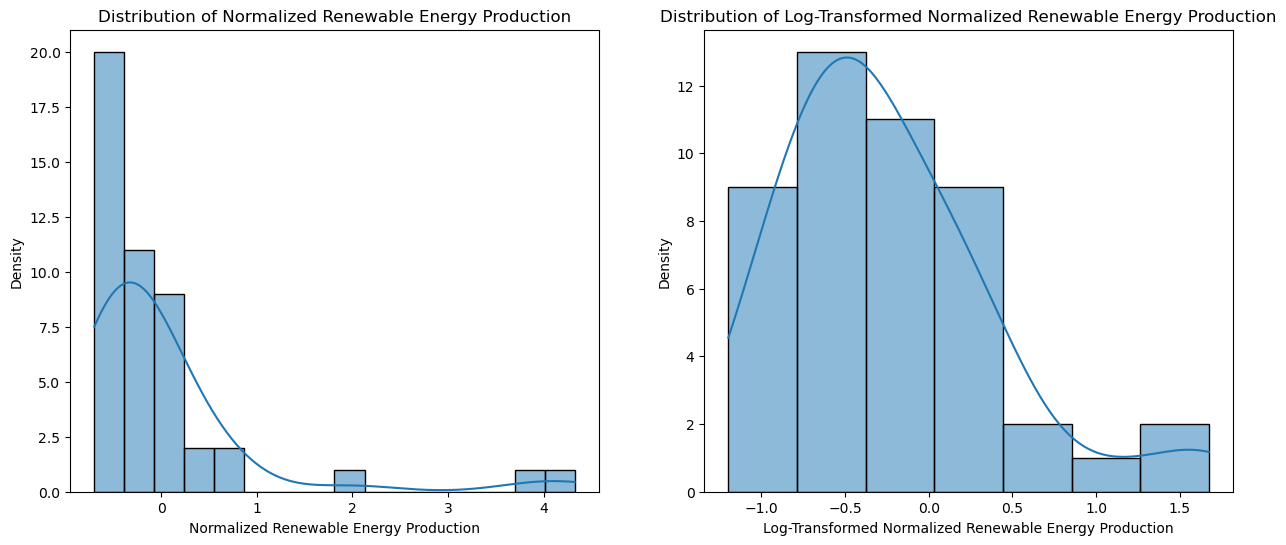

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=data, x='norm_prod', kde=True, ax=ax1)
ax1.set_title('Distribution of Normalized Renewable Energy Production')
ax1.set_xlabel('Normalized Renewable Energy Production')
ax1.set_ylabel('Density')

sns.histplot(data=np.log1p(data['norm_prod']), kde=True, ax=ax2)
ax2.set_title('Distribution of Log-Transformed Normalized Renewable Energy Production')
ax2.set_xlabel('Log-Transformed Normalized Renewable Energy Production')
ax2.set_ylabel('Density')

plt.show()

We can see that the distribution follows an approximately normal distribution when the target variable is log-transformed, making the Gaussian family an appropriate choice. Since the data is right-skewed, we could consider a Gamma family; however, this family does not handle negative values well and our data includes negatives. Poisson or Negative Binomial families would also not be applicable, as our data is continuous, not count data. 

Thus, we will use a Gaussian family with the identity link function, after log-transforming the target variable. 

## 1.4 Building the GLM Model

In [4]:
def prepare(data):
    
    # Select predictors from cleaned dataframe (feature matrix)
    X = data[['norm_water', 'norm_price', 'norm_urb', 'num_plants', 'norm_area']]
    
    # Log-transform target variable
    y = np.log1p(data['norm_prod'])
    
    return X, y

def train_models(X, y, num_splits):

    # Initialize KFold (use cross validation instead of a simple train test split due to sparse data)
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)    

    # Initialize arrays to store predictions
    glm_preds = np.zeros(len(y))
    knn_preds = np.zeros(len(y))
    rf_preds = np.zeros(len(y))

    # Initialize list to hold glm results for each fold
    glm_fold_results = []

    for i_train, j_test in kf.split(X): 
        
        # Split data for this fold
        X_train = X.iloc[i_train]
        X_test = X.iloc[j_test]
        y_train = y.iloc[i_train]
        y_test = y.iloc[j_test]
    
        # Train GLM -> Gaussian family, Identity link
        glm_model = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gaussian())
        glm_results = glm_model.fit()
        glm_fold_results.append(glm_results)
    
        # Train KNN
        knn = KNeighborsRegressor(n_neighbors=3)
        knn.fit(X_train, y_train)
    
        # Train Random Forest
        rf = RandomForestRegressor(n_estimators=50, random_state=42)
        rf.fit(X_train, y_train)
    
        # Make predictions for this fold
        glm_preds[j_test] = glm_results.predict(sm.add_constant(X_test))
        knn_preds[j_test] = knn.predict(X_test)
        rf_preds[j_test] = rf.predict(X_test)

    return glm_fold_results, glm_preds, knn_preds, rf_preds

# Prepare, train, and predict with all 3 models
X, y = prepare(data)
glm_fold_results, y_pred_glm, y_pred_knn, y_pred_rf = train_models(X, y, num_splits=5)

### Notes:
- Used 5 folds to balance bias and variance (since there are 47 states in the dataset, 5 folds ensured each fold had ~37 states for training, and ~9 for testing), from trial and error
-  Used 3 neighbors for KNN because it prioritized reducing overfitting, verified from trial and error (this optimized MSE)
-  Used 50 trees for RF because its accuracy did not visibly improve beyond this number of trees for such a small dataset
- Dropped `norm_wind`, `norm_temp`, `norm_sunlight`, and `political_leaning_encoded` from predictor set from trial and error, as they had high p-values (> 0.5) in the GLM summary and raised the overall GLM MSE

## 1.5 GLM Results and Model Comparison

In [5]:
glm_comparison = []

for i in range(len(glm_fold_results)):
    glm_fold = glm_fold_results[i]
    print("Fold", i+1)
    print(glm_fold.summary())
    fold_summary = {
        'Fold': i+1,
        'R-squared': glm_fold.pseudo_rsquared(),
        'AIC': glm_fold.aic.round(3),
        'Log-Likelihood': glm_fold.llf.round(3),
        'Chi-squared': glm_fold.pearson_chi2,
    }
    glm_comparison.append(fold_summary)
    print("\n")

summary_df = pd.DataFrame(glm_comparison).set_index('Fold')
summary_df

Fold 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:              norm_prod   No. Observations:                   37
Model:                            GLM   Df Residuals:                       31
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                         0.10175
Method:                          IRLS   Log-Likelihood:                -6.9498
Date:                Sat, 14 Dec 2024   Deviance:                       3.1541
Time:                        22:53:03   Pearson chi2:                     3.15
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8890
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5389      0.106     -5.085  

,R-squared,AIC,Log-Likelihood,Chi-squared
Fold,,,,
1,0.889003,25.900,-6.950,3.154103
2,0.792877,39.695,-13.847,4.579322
3,0.937044,30.667,-9.334,3.636265
4,0.866563,41.863,-14.932,4.882158
5,0.900271,38.746,-13.373,4.497618


In [6]:
# Compare evaluation results
eval = {
    'R2': [r2_score(y, y_pred_glm), 
           r2_score(y, y_pred_knn), 
           r2_score(y, y_pred_rf)],
    'MSE': [mean_squared_error(y, y_pred_glm),
            mean_squared_error(y, y_pred_knn),
            mean_squared_error(y, y_pred_rf)]
}
metrics = pd.DataFrame(eval)
metrics.index = ['GLM', 'KNN', 'RF']

print('Model Comparison:')
metrics

Model Comparison:


,R2,MSE
GLM,0.633924,0.143576
KNN,0.149716,0.333482
RF,0.537004,0.181587


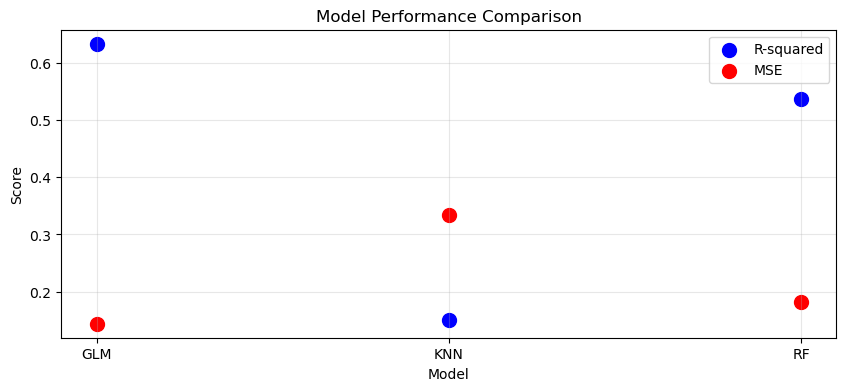

In [7]:
plt.figure(figsize=(10, 4))

# Plot MSE and R-Squared
plt.scatter(metrics.index, metrics['R2'], color='blue', s=100, label='R-squared')
plt.scatter(metrics.index, metrics['MSE'], color='red', s=100, label='MSE')

plt.legend()
plt.xlabel('Model')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.title('Model Performance Comparison')
plt.show()

## 1.6 Prediction Accuracy Visualizations

In [8]:
# Compare Actual vs. Predicted results by state
comparison_df = pd.DataFrame({
        'state': data['state'],
        'actual': y,
        'predicted': y_pred_glm
    }).sort_values('actual', ascending=True)

comparison_df

,state,actual,predicted
5,Delaware,-1.196090,-0.953035
35,Rhode Island,-1.071419,-1.311100
20,Mississippi,-1.015688,-0.452755
41,Vermont,-0.993841,-0.829073
25,New Hampshire,-0.977885,-0.986599
14,Louisiana,-0.909417,-0.480698
44,West Virginia,-0.906389,-0.594238
13,Kentucky,-0.800703,-0.494657
16,Maryland,-0.792038,-0.702810
2,Arkansas,-0.740731,-0.372724


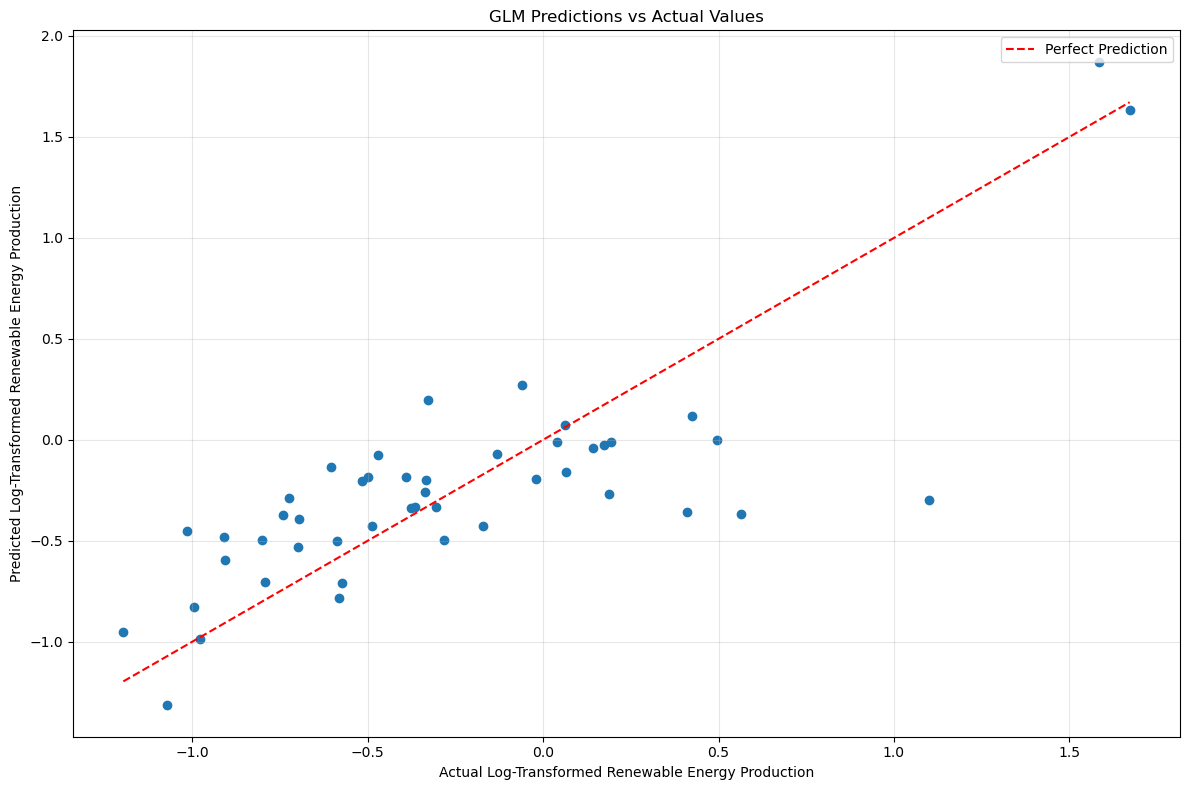

In [9]:
# Plot Actual vs. Predicted Results
plt.figure(figsize=(12, 8))
plt.scatter(comparison_df['actual'], comparison_df['predicted'])

# Add perfect prediction reference line
plt.plot([np.min(comparison_df['actual']), np.max(comparison_df['actual'])], [np.min(comparison_df['actual']), np.max(comparison_df['actual'])], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Log-Transformed Renewable Energy Production')
plt.ylabel('Predicted Log-Transformed Renewable Energy Production')
plt.title('GLM Predictions vs Actual Values')
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

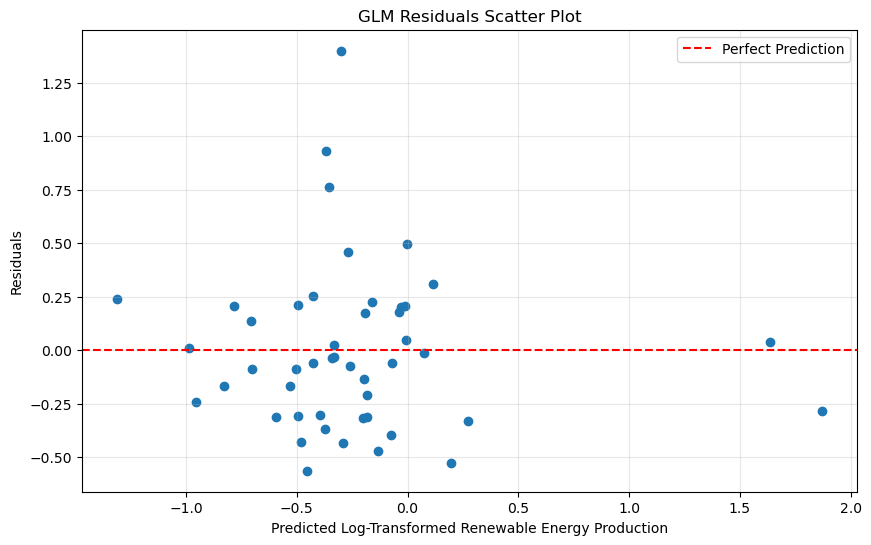

In [10]:
residuals = y - y_pred_glm

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_glm, residuals)

# Add perfect prediction reference line
plt.axhline(y=0, color='r', linestyle='--', label='Perfect Prediction')

plt.xlabel('Predicted Log-Transformed Renewable Energy Production')
plt.ylabel('Residuals')
plt.title('GLM Residuals Scatter Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

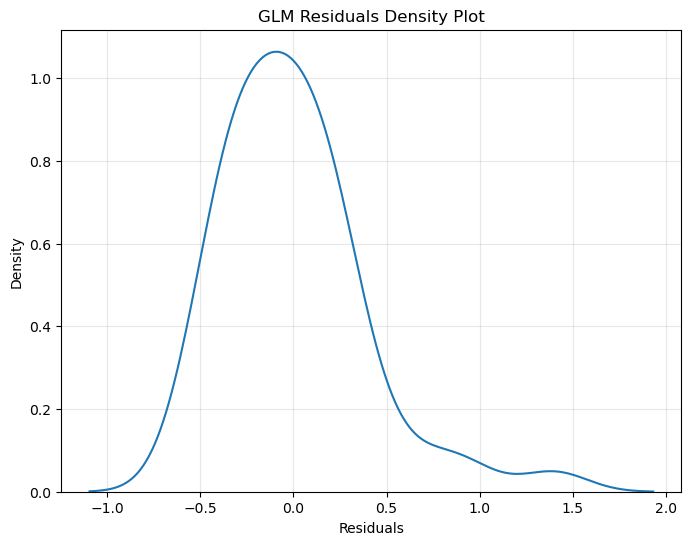

In [11]:
# Test whether residual distribution is approx. normal to see whether the GLM is capturing variance effectively

plt.figure(figsize=(8, 6))
sns.kdeplot(residuals)
plt.title('GLM Residuals Density Plot')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.show()

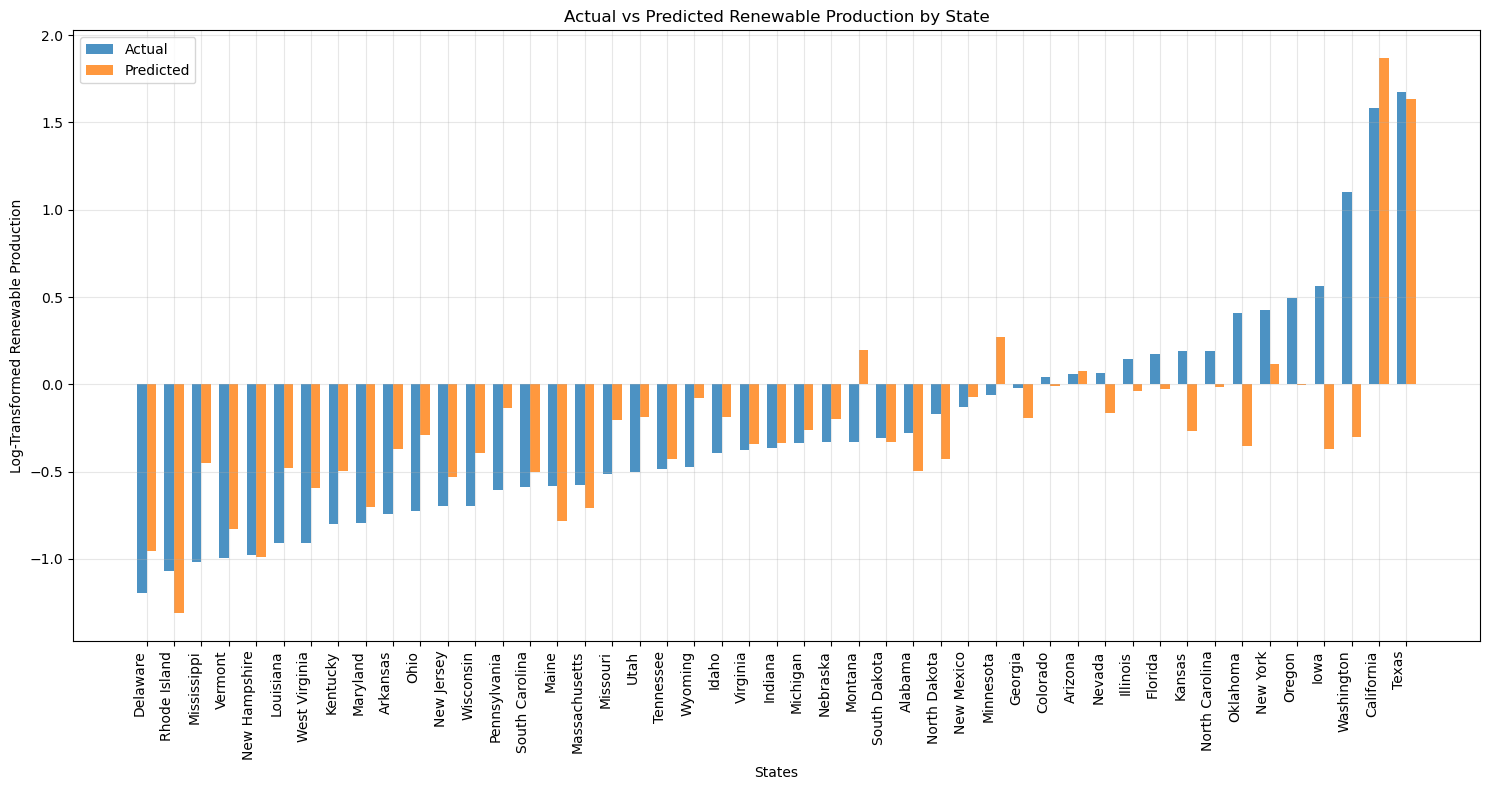

In [12]:
plt.figure(figsize=(15, 8))
x = np.arange(len(comparison_df))
width = 0.35  
plt.bar(x - width/2, comparison_df['actual'], width, label='Actual', alpha=0.8)
plt.bar(x + width/2, comparison_df['predicted'], width, label='Predicted', alpha=0.8)
    
plt.xlabel('States')
plt.ylabel('Log-Transformed Renewable Production')
plt.title('Actual vs Predicted Renewable Production by State')
plt.xticks(x, comparison_df['state'], rotation=90, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# Research Question 2: Causal Inference

**Research Question**: What is the causal relationship between average annual electricity price (cents / kWh) and average annual carbon emissions (lb/mWk) at the state level?

## 2.1 Load and Clean Data

### Causal Inference Setup

We are investigating the causal effect of annual electricity price (cents/kWh) on the average carbon emissions (lb/mWh) at the state level in 2023. We gathered average annual electricity price and carbon emissions data for each state in 2023. Since the average annual electricity price is continuous data, we binarized the treatment to conduct the causal inference analysis. We divided states into two treatment groups: above-average electricity price (1) and below-average electricity price (0). We then identified confounding variables that affect both the treatment (average annual electricity price) and the outcome (average annual carbon dioxide emissions). We categorized our confounding variables into four groups: (1) Geographical Factors, (2) Weather conditions, (3) Electricity Usage Profile, and (4) State Policy. Below is an overview of data on our confounding variables:

### Confounding Variables

#### (1) Geographical Factors:
- `total area (miles^2)`: Size of the State ($\text{miles}^2$).
- `State Population`: Total population of the state by 2020 Census.
- `Percent of Urbanized Population`: Percentage of the population living in urbanized land by 2020 census ($\%$).
- `Water Percentage`: Percentage of state area covered by water ($\%$).

#### (2) Weather Conditions:
- `Average Annual Temperature (F)`: Average annual temperature of the state ($F$)
- `Average Annual Precipitation (in)`: Average annual precipitation of the state ($in$)
- `Average Annual Sunlight Exposure (kJ/m^2)`: Average annual sunlight exposure ($kJ/m^2$)

#### (3) Electricity Usage Profile:
- `Consumption of Electricity by State`: Total annual consumption of electricity by state in 2023 (thousand $MWh$)
- `Production of Electricity by State (thousand MWh)`: Total annual electricity production by state in 2023 (thousand $MWh$)
- `Renewable Sources`: Annual electricity produced by renewable sources by the state in 2023 (thousand $MWh$)
- `Non-renewable Sources`: Annual electricity produced by non-renewable sources by the state in 2023 (thousand $MWh$)
- `Number of Power Plants`: Number of power plants by state in 2023 (thousand $MWh$)

#### (4) State Policy:
- `Party`: Results of 2020 Presidential election by state
- `Renewable Policies`: Number of Renewable Energy Policies & Incentives per state in 2023

### File structure

#### Cleaned dataset:
- `total_data.csv`: cleaned and aggregated data from different sources at the state level. See `causal_inference/eda.ipynb` for details on data cleaning and merging. See `cleaned_datasets` for the cleaned datasets.

In [13]:
total = pd.read_csv('total_data.csv')
a = pd.read_csv('cleaned_datasets/cleaned_state_political_party.csv')
total['Party'] = a['Political Party'].map({'D': 1, 'R': 0})
total.head()

,State,Electricity Price (cents/kWh),CO2 (lb/MWh),renew prod (1000MWh),nonrenew prod (1000MWh),production (1000MWh),Urban Population,Urban Population (%),avg annual temp (F),avg annual precip (in),avg annual sunlight (kJ/m^2),num_plants,num_renewable,num_nonrenewable,total area (mile^2),water percentage,total consumption,Renewable Policies,Party
0,Maine,17.44,336.612,8794,4736,13530,526309.0,38.6,41.0,45.5,3815.0,196,170,26,"35,380",12.80%,35399,57,0
1,Massachusetts,21.27,851.739,8917,17462,26379,6416895.0,91.3,47.9,48.6,3944.0,632,555,78,"10,554",26.10%,131292,193,0
2,New Hampshire,21.07,302.928,2784,16224,19008,803420.0,58.3,43.8,47.9,3891.0,60,38,22,"9,349",4.20%,33311,76,1
3,Rhode Island,19.30,811.317,1684,7023,8707,999191.0,91.1,50.1,49.1,3989.0,100,86,14,"1,545",33.10%,53421,61,0
4,Vermont,16.99,35.627,2589,9,2598,225850.0,35.1,42.9,46.0,3826.0,118,105,13,"9,616",4.20%,113,116,1


Binarize the treatment (`Electricity Price (cents/kWh)`) and add it to `total` as `Treatment`:

In [14]:
ave_treatment = np.mean(total['Electricity Price (cents/kWh)'])
treatment = [0 if value <= ave_treatment else 1 for value in total['Electricity Price (cents/kWh)']]
total.insert(2, 'Treatment', treatment)
total['total area (mile^2)'] = total['total area (mile^2)'].str.replace(',', '').astype(int)
total['water percentage'] = total['water percentage'].str.replace('%', '').astype(float) / 100
total.head()

,State,Electricity Price (cents/kWh),Treatment,CO2 (lb/MWh),renew prod (1000MWh),nonrenew prod (1000MWh),production (1000MWh),Urban Population,Urban Population (%),avg annual temp (F),avg annual precip (in),avg annual sunlight (kJ/m^2),num_plants,num_renewable,num_nonrenewable,total area (mile^2),water percentage,total consumption,Renewable Policies,Party
0,Maine,17.44,1,336.612,8794,4736,13530,526309.0,38.6,41.0,45.5,3815.0,196,170,26,35380,0.128,35399,57,0
1,Massachusetts,21.27,1,851.739,8917,17462,26379,6416895.0,91.3,47.9,48.6,3944.0,632,555,78,10554,0.261,131292,193,0
2,New Hampshire,21.07,1,302.928,2784,16224,19008,803420.0,58.3,43.8,47.9,3891.0,60,38,22,9349,0.042,33311,76,1
3,Rhode Island,19.30,1,811.317,1684,7023,8707,999191.0,91.1,50.1,49.1,3989.0,100,86,14,1545,0.331,53421,61,0
4,Vermont,16.99,1,35.627,2589,9,2598,225850.0,35.1,42.9,46.0,3826.0,118,105,13,9616,0.042,113,116,1


## 2.1 EDA

### Treatment and Outcome

First, we visualized the distributions of the treatment and the outcome to get insights into their relationship. 

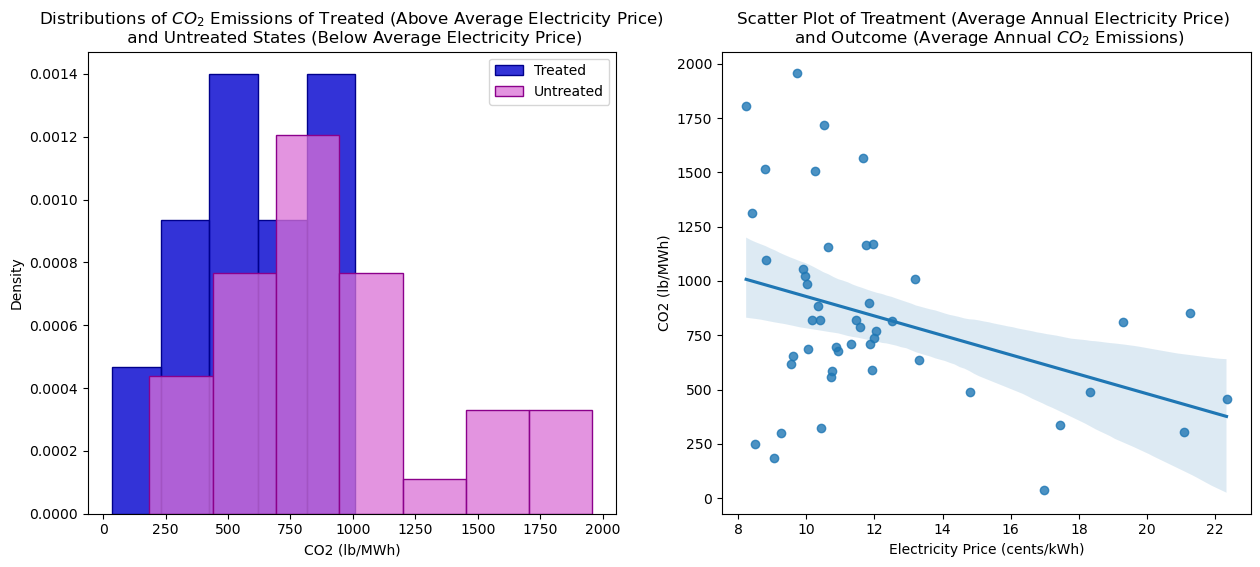

In [15]:
treated = total[total['Treatment'] == 1]
untreated = total[total['Treatment'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(treated['CO2 (lb/MWh)'], stat='density', label='Treated',
            color='mediumblue', edgecolor='darkblue', alpha=0.8, ax=axes[0])

sns.histplot(untreated['CO2 (lb/MWh)'], stat='density', label='Untreated',
             color='orchid', edgecolor='darkmagenta', ax=axes[0])

axes[0].set_title('Distributions of $CO_2$ Emissions of Treated (Above Average Electricity Price) \n and Untreated States (Below Average Electricity Price)')
axes[0].legend()

sns.regplot(x=total['Electricity Price (cents/kWh)'], y=total['CO2 (lb/MWh)'], ax=axes[1])
axes[1].set_title('Scatter Plot of Treatment (Average Annual Electricity Price) \n and Outcome (Average Annual $CO_2$ Emissions)')
plt.savefig('plots/treatment-outcome.png', dpi=300, bbox_inches='tight')

From the distributions of average annual $CO_2$ emissions (the plot to the left), we saw that the treated and untreated groups had overlapping regions which indicated that comparisons between treated and untreated groups are possible and could produce meaningful results after adjusting for covariates. In addition, we analyzed the relationships between our treatment and outcome variables to gather an initial understanding of the relationship. From the scatter plot with a fitted regression line (to the right), we observed the relationship between the treatment and outcome to be slightly negative.

### Confounding Variables

We also wanted to look at the covariate relationships among the confounding variables, the treatment, and the outcome to confirm the validity of our confounders and look for any colinear relationships. We generated pair-wise plots among the treatment, outcome, and each category of confounders.

#### Geographical Confounders

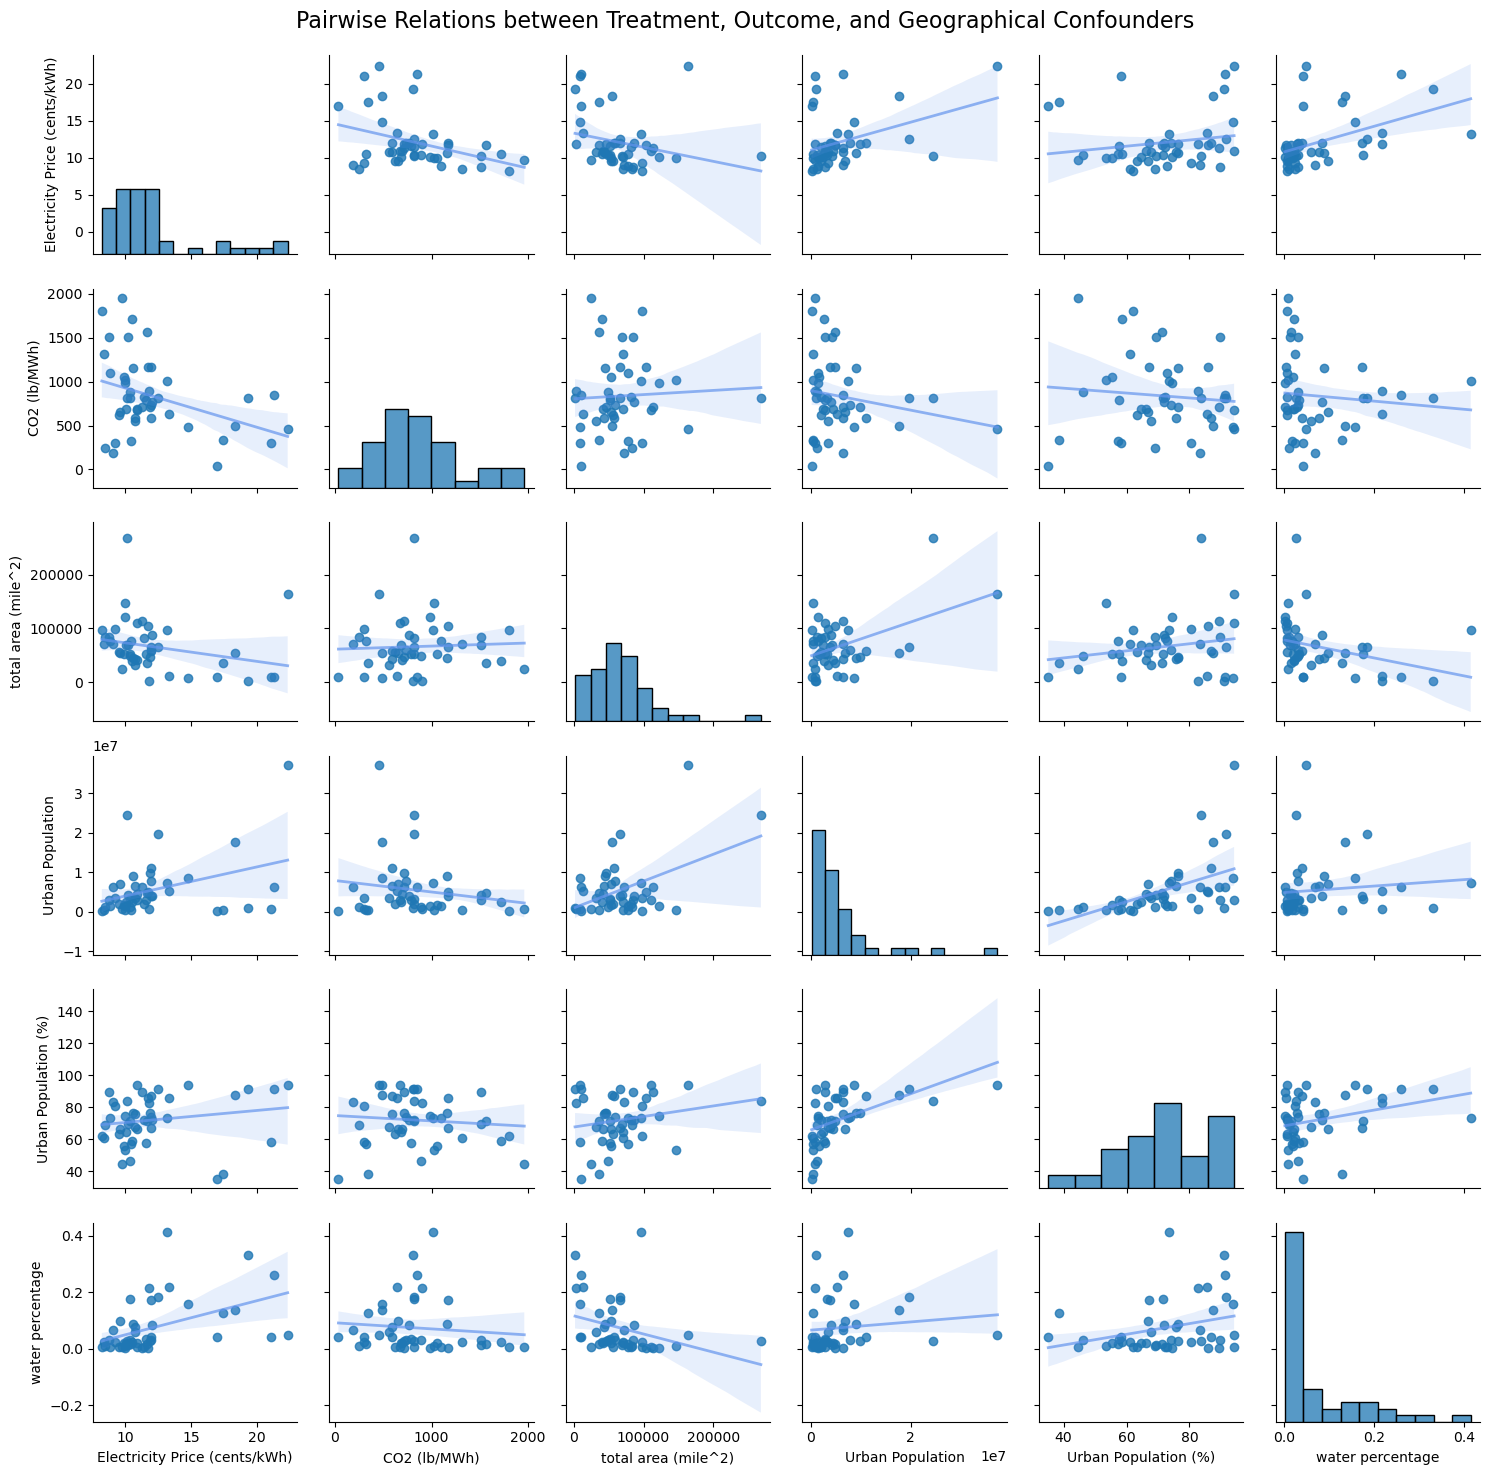

In [16]:
geographical = ['Electricity Price (cents/kWh)', 'CO2 (lb/MWh)', 'total area (mile^2)',
               'Urban Population', 'Urban Population (%)', 'water percentage']
g = sns.pairplot(total.loc[:, geographical], diag_kind='hist', 
             kind='reg', plot_kws={'line_kws': {'color': 'cornflowerblue', 'linewidth': 2, 'alpha': 0.7}})
g.fig.suptitle('Pairwise Relations between Treatment, Outcome, and Geographical Confounders', size=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
plt.savefig('plots/pairwise-geographical.png', dpi=300, bbox_inches='tight')
plt.show();

#### Weather Conditions

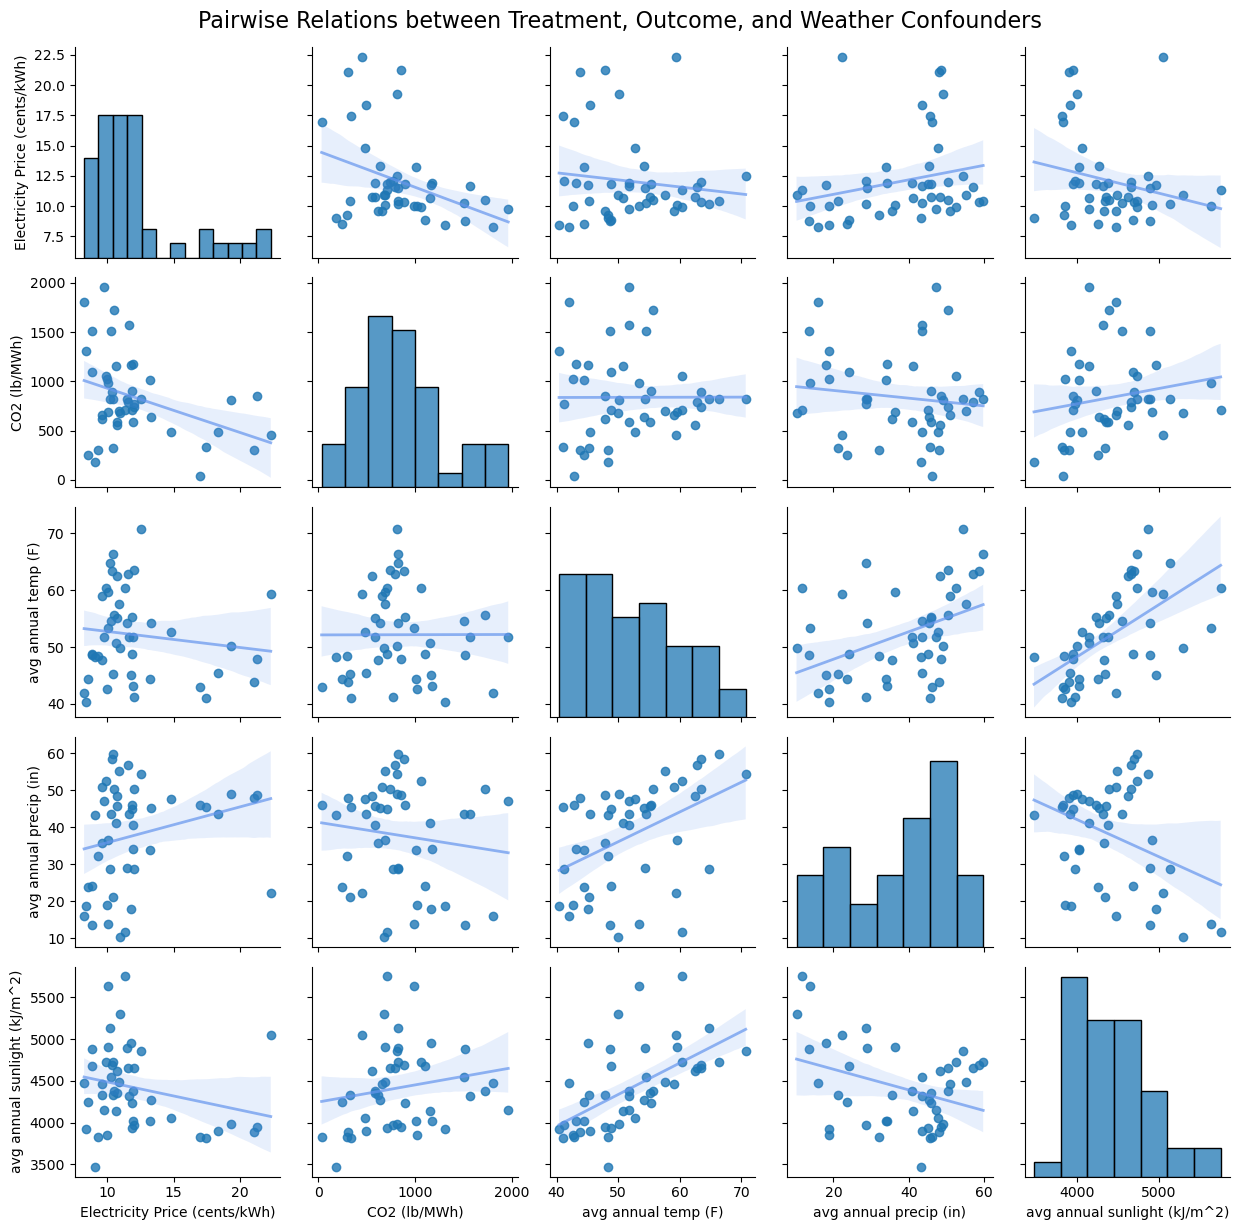

In [17]:
weather = ['Electricity Price (cents/kWh)', 'CO2 (lb/MWh)', 'avg annual temp (F)',
          'avg annual precip (in)', 'avg annual sunlight (kJ/m^2)']
g = sns.pairplot(total.loc[:, weather], diag_kind='hist', 
             kind='reg', plot_kws={'line_kws': {'color': 'cornflowerblue', 'linewidth': 2, 'alpha': 0.7}})
g.fig.suptitle('Pairwise Relations between Treatment, Outcome, and Weather Confounders', size=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
plt.savefig('plots/pairwise-weather.png', dpi=300, bbox_inches='tight')
plt.show();

#### Electricity Usage Profile

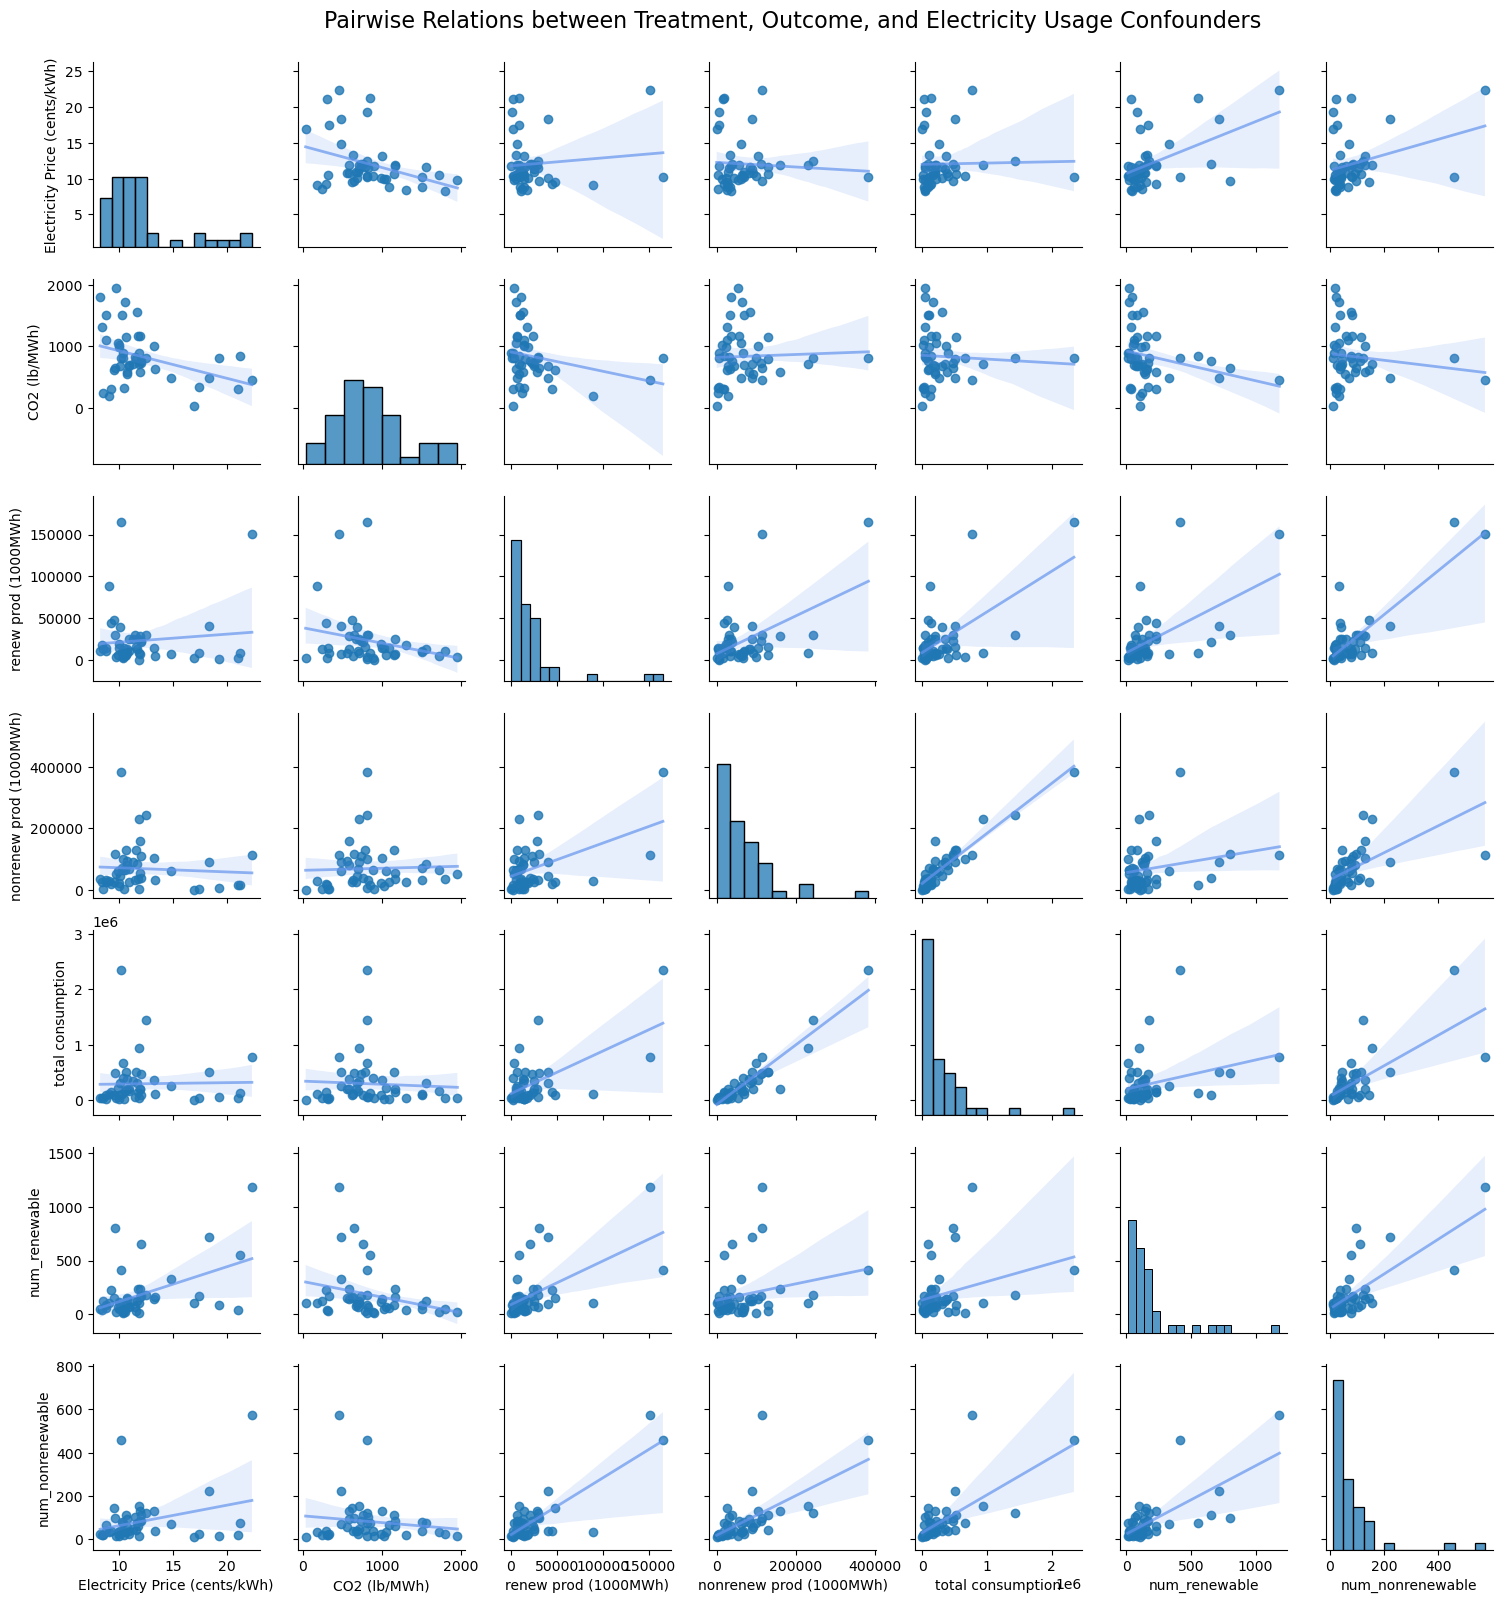

In [18]:
usage = ['Electricity Price (cents/kWh)', 'CO2 (lb/MWh)', 
                      'renew prod (1000MWh)', 'nonrenew prod (1000MWh)','total consumption', 
                      'num_renewable','num_nonrenewable']
g = sns.pairplot(total.loc[:, usage], diag_kind='hist', 
             kind='reg', plot_kws={'line_kws': {'color': 'cornflowerblue', 'linewidth': 2, 'alpha': 0.7}})
g.fig.suptitle('Pairwise Relations between Treatment, Outcome, and Electricity Usage Confounders', size=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95, left=0.1, right=0.9, bottom=0.1)
plt.savefig('plots/pairwise-usage.png', dpi=300, bbox_inches='tight')
plt.show();

#### State Policy
Since both of the confounders here are binary data, we did not visualize them using a pairwise plot.

### EDA Analysis

From the three pairwise plots among the treatment, outcome, and groups of confounders, we observed that the confounders we identified have non-zero relationships with both the treatment and the outcome, confirming their confoundedness. However, we also noticed that there are a lot of colinear relationships among our confounders which could possibly increase bias in our analyses and is potentially a factor we need to consider.

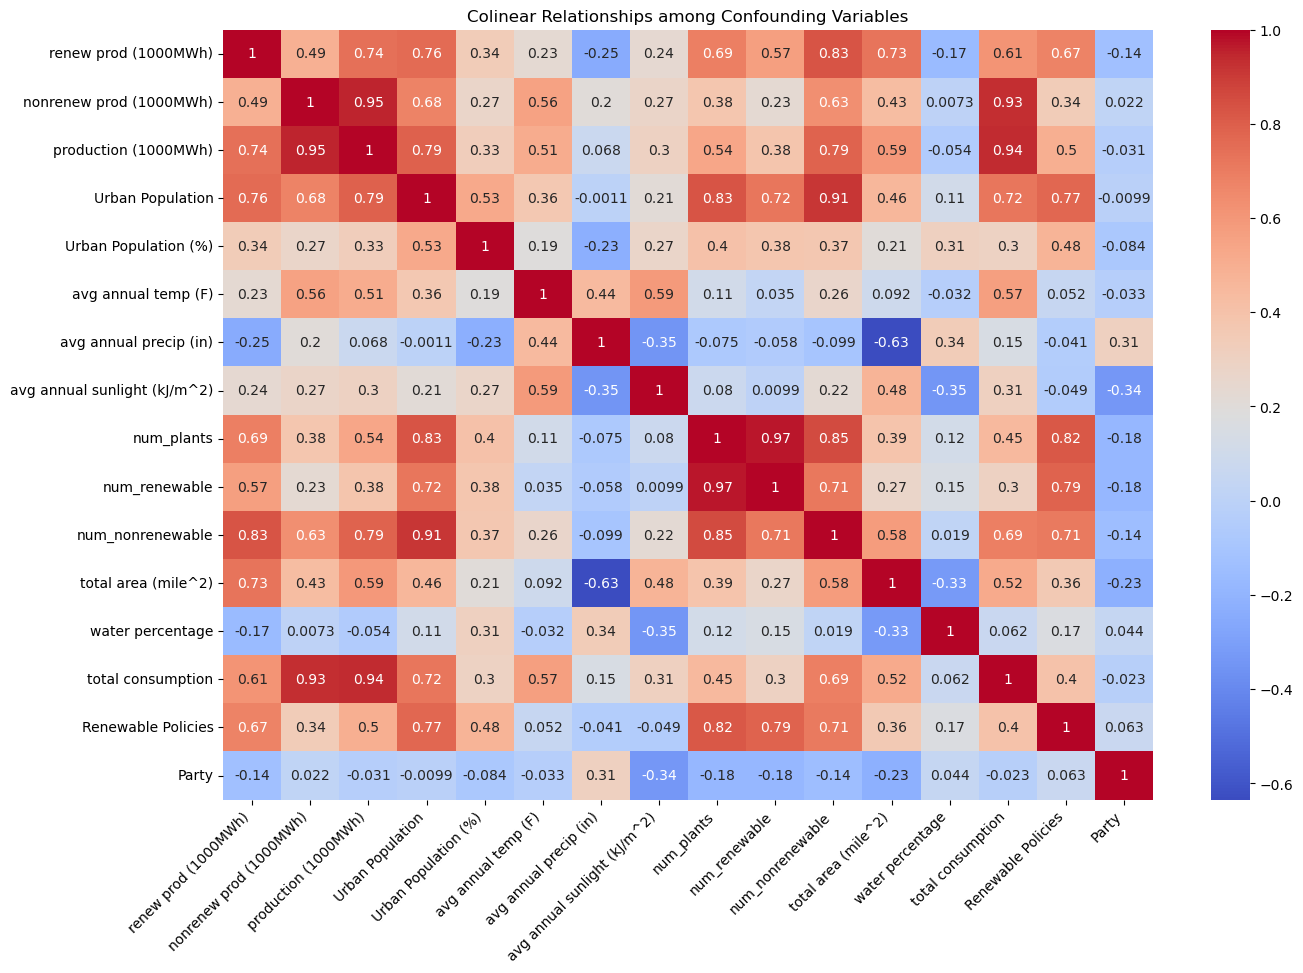

In [35]:
corr = total.iloc[:, 4:].corr()
plt.figure(figsize=(15, 10))  
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title('Colinear Relationships among Confounding Variables')
plt.xticks(rotation=45, ha='right')
plt.savefig('plots/confounders-heatmap.png', dpi=300, bbox_inches='tight')
plt.show();

## 2.3 Causal Inference

To control for the confounding variables, we decided to use Inverse Propensity Score Weighting (IPSW) to calculate the Average Treatment Effect (ATE). First, we used a logistic regression model to calculate the propensity scores.

### More Library Imports

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Vanilla Propensity Scoring

Using the Inverse Propensity Score Weighting formula to calculate the Average Treatment Effect ($\tau$):

\begin{equation}
    \tau_{\text{IWPS}} = \frac{1}{n_1}\sum_{i;T_i=1}\frac{Y_i}{e(X_i)} - \frac{1}{n_0}\sum_{i;T_i=0}\frac{Y_i}{1-e(X_i)}
\end{equation}

where
- $n_1$: sample size of the treated group,
- $n_0$: sample size of the untreated group,
- $T_i$: the treatment indicator,
- $e(X_i)$: the propensity scores,
- $Y_i$: the outcome.

In [21]:
def calculate_propensity(data):
    if isinstance(data, pd.DataFrame):
        confounders = data.iloc[:, 4:]
    else:
        confounders = data
    log_reg = LogisticRegression(max_iter=20000)
    log_reg.fit(confounders, data['Treatment'])
    propensity_scores = log_reg.predict_proba(confounders)[:, 1] 
    return propensity_scores

propensity_scores = calculate_propensity(total)

# Propensity Scores for each State
propensity_scores

array([2.65782636e-01, 9.95578623e-01, 3.83030790e-01, 7.34239993e-01,
       5.59924626e-01, 9.91055177e-01, 9.99713221e-01, 6.26296121e-04,
       3.51887842e-03, 5.72242519e-02, 6.12944330e-02, 3.37200790e-01,
       2.01692206e-01, 1.48991967e-03, 5.02709210e-03, 6.65888451e-02,
       3.64263837e-02, 2.90661442e-02, 6.78194904e-03, 7.41198948e-02,
       7.58442347e-01, 8.74740755e-01, 6.48806703e-02, 9.50344967e-01,
       6.37836801e-03, 7.05435319e-03, 4.07343056e-01, 1.40311655e-02,
       1.35962733e-04, 4.21211970e-02, 3.30535776e-02, 1.16678748e-01,
       1.79166743e-02, 3.49658194e-02, 3.13415343e-03, 8.69110713e-11,
       1.24436656e-02, 1.42851003e-01, 1.80219109e-01, 8.51937609e-03,
       4.04653180e-02, 1.49655905e-02, 1.46993882e-01, 4.20211985e-03,
       9.99997678e-01, 1.13198696e-02, 6.52852667e-04])

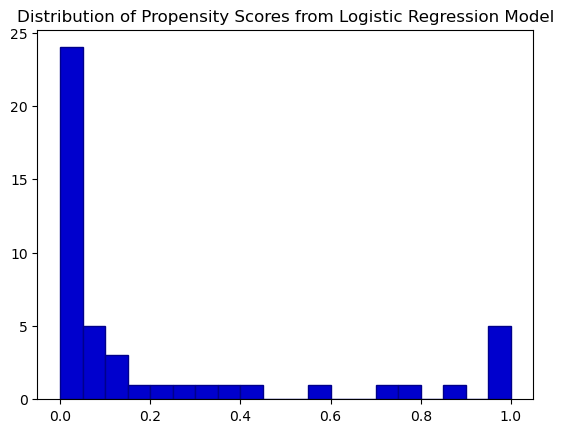

In [22]:
plt.hist(propensity_scores, bins=20, color='mediumblue', edgecolor='darkblue')
plt.title("Distribution of Propensity Scores from Logistic Regression Model")
plt.savefig('plots/propensity-dist.png', dpi=300, bbox_inches='tight')
plt.show()

From the distribution of propensity scores, we observed that most of the propensity scores are close to 0, which indicates that for many observations, the probability of receiving treatment given their covariates is very low. This indicates that many observations are highly unlikely to receive treatment (or control) based on their covariates. This could potentially produce extremely high weights for treated individuals, leading to high variance and unstable estimates. As a result, using Inverse Propensity Score Weighting (IPSW) would potentially produce a biased estimate of ATE and might not be a reliable result. Therefore, we decided to use **Stabilized Inverse Probability Weighting (SIPW)** to reduce the influence of extreme weights.

Average Traemtne Effect is calcualted by Stabilized Inverse Probability Weighting (SIPW) as:

\begin{equation}
    \tau_{\text{SIPW}} = \frac{1}{n_1}\sum_{i;T_i=1}\frac{P(T=1) \cdot Y_i}{e(X_i)} - \frac{1}{n_0}\sum_{i;T_i=0}\frac{(1-P(T=1)) \cdot Y_i}{1-e(X_i)}
\end{equation}

where
- $T_i$: the treatment indicator,
- $P(T=1)$: The marginal probabilities of treatment and control, respectively,
- $e(X_i)$: the propensity scores,
- $Y_i$: the outcome.

In [23]:
def stabilized_ate(data, propensity):
    copy = data.copy()
    copy.insert(1, 'Propensity', propensity)
    copy = copy[(copy['Propensity'] >= 0.01) & (copy['Propensity'] <= 0.9)]
    p_treat = total['Treatment'].mean()
    treatment1 = copy.loc[copy['Treatment'] == 1]
    treatment0 = copy.loc[copy['Treatment'] == 0]
    tau = np.mean(p_treat * treatment1['CO2 (lb/MWh)'] / treatment1['Propensity']) - np.mean((1-p_treat) * treatment0['CO2 (lb/MWh)'] / (1 - treatment0['Propensity'])) 
    return tau

In [24]:
ate_stabilized = stabilized_ate(total, propensity_scores)
ate_stabilized

-121.77606115507217

In [25]:
from joblib import Parallel, delayed # for parallel processing

def run_ps(df):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df.iloc[:, 4:], df['Treatment']).predict_proba(df.iloc[:, 4:])[:, 1]
    return stabilized_ate(df, ps)

bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(total.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)
ates = ates[~np.isnan(ates)]

In [26]:
print(f"ATE: {ates.mean()}")
print(f"95% Confidence Interval: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: -197.40986288207787
95% Confidence Interval: (-1203.9578106670785, 2567.786952925795)


# 2.3 Non-parametric Method to Obtain Propensity Scores

In [27]:
!pip install -q torch torchvision torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm

After our initial attempt of conducting the causal inference with propensity scores obtained by a Logistic Regression Model and Average Treatment Effect (ATE) calculated through **Stabilized Inverse Probability Weighting (SIPW)**, we decided to use a non-parametric method to infer the propensity scores.

In [28]:
X = total.iloc[:, 4:]
T = total['Treatment']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, T_train, T_test = train_test_split(X_scaled, T, test_size=0.2)

T_train = np.array(T_train)
T_test = np.array(T_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
T_test_tensor = torch.tensor(T_test, dtype=torch.float32).unsqueeze(1)

class PropensityNet(nn.Module):
    def __init__(self, input_dim):
        super(PropensityNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),                 
            nn.Dropout(0.4),            
            nn.Linear(256, 64),          
            nn.ReLU(),                  
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),   
            nn.ReLU(),                  
            nn.Dropout(0.3),            
            nn.Linear(32, 16),
            nn.ReLU(),                  
            nn.BatchNorm1d(16),           
            nn.Linear(16, 8),
            nn.ReLU(),                  
            nn.Dropout(0.2),            
            nn.Linear(8, 1),  
            nn.Sigmoid()                
        )
    
    def forward(self, x):
        return self.network(x)

input_dim = X_train_tensor.shape[1]
model = PropensityNet(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Train the Model
num_epochs = 100
batch_size = 16

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, T_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for batch_X, batch_T in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_T)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Classify as 1 if score >= 0.5, else 0
        predictions = (outputs >= 0.5).float()  
        correct_preds += (predictions == batch_T).sum().item()
        total_preds += batch_T.size(0)

        epoch_loss += loss.item()

    accuracy = correct_preds / total_preds  # Calculate accuracy

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    propensity_scores_nn = model(X_tensor).numpy()

Epoch [10/100], Loss: 0.1913, Accuracy: 0.9189
Epoch [20/100], Loss: 0.3640, Accuracy: 0.8919
Epoch [30/100], Loss: 0.0814, Accuracy: 1.0000
Epoch [40/100], Loss: 0.0678, Accuracy: 1.0000
Epoch [50/100], Loss: 0.0911, Accuracy: 0.9730
Epoch [60/100], Loss: 0.0495, Accuracy: 1.0000
Epoch [70/100], Loss: 0.0364, Accuracy: 1.0000
Epoch [80/100], Loss: 0.1684, Accuracy: 0.9730
Epoch [90/100], Loss: 0.1019, Accuracy: 1.0000
Epoch [100/100], Loss: 0.0416, Accuracy: 0.9730


In [29]:
ate_stabilized_nn = stabilized_ate(total, propensity_scores_nn)
ate_stabilized_nn

-539.4496336017926

In [33]:
def bootstrap_nn(data, n_bootstrap=1000, num_epochs=50, batch_size=16, lr=1e-3):
    ate_values = []

    for i in range(n_bootstrap):
        bootstrap_sample = data.sample(frac=1, replace=True).reset_index(drop=True)
        X = bootstrap_sample.iloc[:, 4:]
        T = bootstrap_sample['Treatment']
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, T_train, T_test = train_test_split(X_scaled, T, test_size=0.2)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32).unsqueeze(1)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        input_dim = X_train_tensor.shape[1]
        model = PropensityNet(input_dim)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, T_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        model.train()
        for epoch in range(num_epochs):
            for batch_X, batch_T in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_T)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            propensity_scores = model(X_tensor).numpy().flatten()

        ate = stabilized_ate(bootstrap_sample, propensity_scores)
        ate_values.append(ate)

    # We make sure to get rid of `nan` values that might arise due to unbalanced sampling
    # Since the dataset is small (only 47 points), there is a possibility, though small, that a sample might only 
    # contain one group (all treatment or all control), leading to `nan` values.
    ate_values = np.array(ate_values)
    ate_values = ate_values[~np.isnan(ate_values)]
    lower_bound = np.percentile(ate_values, 2.5)
    upper_bound = np.percentile(ate_values, 97.5)
    mean_ate = np.mean(ate_values)
    
    print("\nBootstrap Results:")
    print(f"Mean ATE: {mean_ate:.4f}")
    print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")
    
    return ate_values, (lower_bound, upper_bound)

ate_values, confidence_interval = bootstrap_nn(total)


Bootstrap Results:
Mean ATE: -674.0863
95% Confidence Interval: [-969.2708, -421.3886]


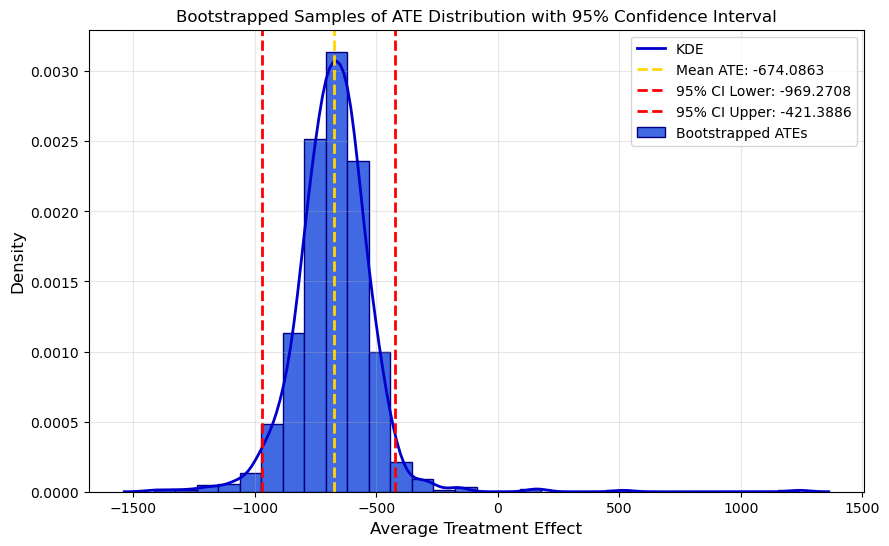

In [34]:
def visualize_bootstrapped_ate(ate_values, confidence_interval, save_path=None):
    
    lower_bound, upper_bound = confidence_interval
    mean_ate = np.mean(ate_values)
    
    plt.figure(figsize=(10, 6))
    
    sns.histplot(ate_values, bins=30, color='royalblue', 
                 edgecolor='navy', label="Bootstrapped ATEs", 
                 stat="density", alpha=1)

    sns.kdeplot(ate_values, color='mediumblue', linewidth=2, label="KDE")
    
    plt.axvline(mean_ate, color='gold', linestyle='--', linewidth=2, label=f"Mean ATE: {mean_ate:.4f}")
    plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2, label=f"95% CI Lower: {lower_bound:.4f}")
    plt.axvline(upper_bound, color='red', linestyle='--', linewidth=2, label=f"95% CI Upper: {upper_bound:.4f}")
    
    plt.title("Bootstrapped Samples of ATE Distribution with 95% Confidence Interval", fontsize=12)
    plt.xlabel("Average Treatment Effect", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

visualize_bootstrapped_ate(ate_values, confidence_interval, 'plots/boot-ate.png')